In [183]:
import numpy as np
import matplotlib.pyplot as plt
import random 


def initialize_particles(n, radius):
    """ Initialize particles at edge of disc. """
    angles = np.random.uniform(0, 2 * np.pi, n)
    radii = radius 
    x = radii * np.cos(angles)
    y = radii * np.sin(angles)
    return np.column_stack((x, y))
    
def initialize_particles_center_bias(n, radius, center_bias=0.3):
    """ Initialize particles with a bias towards the center. """
    # angles = np.random.uniform(0, 2 * np.pi, n)
    angles = np.random.rand(n)*2*np.pi
    radii = radius * np.sqrt(np.random.uniform(0, center_bias, n))  # Bias towards center of circle
    x = radii * np.cos(angles)
    y = radii * np.sin(angles)
    return np.column_stack((x, y))

def compute_forces_and_energy_vectorized(particles):
    """ Compute the forces and energy for the current configuration of particles using vectorized operations. """
    
    n = len(particles)
    # calculate distance vectors between particles
    diff = particles[:, np.newaxis, :] - particles[np.newaxis, :, :]
    distances = np.linalg.norm(diff,  axis=2)
    np.fill_diagonal(distances, np.inf)
    # calculate total energy of the system and force vectors between particles
    energy = np.sum(1 / distances[np.triu_indices(n, 1)])
    forces = np.sum(diff / (distances[:,:,np.newaxis]**3), axis=1)

    return forces, energy

def update_particle_positions(particles, step_size, radius):
    """ Update the positions of particles randomly and handle infinitely hard wall boundary conditions. """
    
    new_particles = np.copy(particles)
    for i,particle in enumerate(new_particles):
        # Generate a random direction
        angle = np.random.uniform(0, 2 * np.pi)
        direction = np.array([np.cos(angle), np.sin(angle)])

        # Update the particle position in the random direction
        particle += direction * step_size * np.random.uniform(0, 2)

        # Check if the particle is outside the boundary
        distance_from_center = np.linalg.norm(particle)

        if distance_from_center > radius:
            # If outside, reposition it on the boundary
            particle = particle / distance_from_center * radius
        
        new_particles[i] = particle
    
    return new_particles

def update_particle_positions_force_bias(particles, step_size, radius, forces):
    """ Update the positions of particles randomly and handle infinitely hard wall boundary conditions. """
    
    new_particles = np.copy(particles)
    for i,(particle,force) in enumerate(zip(new_particles, forces)):
        # Compute angles based on the force of surrounding particles and randomness
        force_angle = np.arctan2(force[1], force[0])
        random_angle = np.random.uniform(0, 2 * np.pi)
        
        # Combine force angle and random angle 
        tot_angle = force_angle + 0.1*random_angle
        direction = np.array([np.cos(tot_angle), np.sin(tot_angle)])

        # Update the particle position in the random direction
        particle += direction * step_size

        # Check if the particle is outside the boundary
        distance_from_center = np.linalg.norm(particle)

        if distance_from_center > radius:
            # If outside, reposition it on the boundary
            particle = particle / distance_from_center * radius
        
        new_particles[i] = particle
    
    return new_particles


# def simulate_charged_particles_annealing(n, radius, steps, initial_step_size, final_step_size, initial_temp, final_temp):
#     """ Simulate the charged particles with simulated annealing, updating all particles at once. """
#     particles = initialize_particles_center_bias(n, radius)
#     min_energy_config = None
#     min_energy = np.inf
#     energies = []

#     temperature = initial_temp
#     step_size = initial_step_size

#     # Calculate the cooling and step size rates
#     cooling_rate = (final_temp / initial_temp) ** (1 / steps)
#     step_rate = (final_step_size / initial_step_size) ** (1 / steps)

#     for step in range(steps):

#         forces, current_energy = compute_forces_and_energy_vectorized(particles)

#         # Calculate new positions for all particles
#         # new_particles = update_particle_positions(particles, step_size, radius)
#         new_particles = update_particle_positions_force_bias(particles, step_size, radius, forces)
#         new_energy = compute_forces_and_energy_vectorized(new_particles)[1]

#         # Decide whether to accept the new configuration
#         if new_energy < current_energy or np.random.rand() < np.exp((current_energy - new_energy) / temperature):
#             particles = new_particles
#             current_energy = new_energy

#         # if step % 100 == 0:
#         #     temperature*=0.9
#         if step % 1000 == 0:
#             print(step, np.exp((current_energy - new_energy) / temperature), temperature)

#         # Update energy, temperature, and step size after each step
#         energy = compute_forces_and_energy_vectorized(particles)[1]
#         energies.append(energy)

#         if energy < min_energy:
#             min_energy = energy
#             min_energy_config = particles.copy()

       
#         step_size *= step_rate

#     return min_energy_config, min_energy, energies


def simulate_charged_particles_individual_steps(n, radius, steps, initial_step_size, final_step_size, initial_temp, final_temp, markov_chain=100, cooling=False):
    """ Simulate the charged particles with simulated annealing, checking each individual particle move. """
    particles = initialize_particles_center_bias(n, radius)
    min_energy_config = None
    min_energy = np.inf
    energies = []

    temperature = initial_temp
    step_size = initial_step_size

    # Calculate the cooling and step size rates
    # cooling_rate = (final_temp / initial_temp) ** (100 / steps)
    step_rate = (final_step_size / initial_step_size) ** (1 / steps)

    for step in range(steps):
        
        for i in range(n):
            forces, current_energy = compute_forces_and_energy_vectorized(particles)

            # Try moving one particle
            new_particles = particles.copy()
            new_particles[i] = update_particle_positions_force_bias([particles[i]], step_size, radius, [forces[i]])[0]
            # new_particles[i] = update_particle_positions([particles[i]], step_size, radius)[0]
            new_energy = compute_forces_and_energy_vectorized(new_particles)[1]

            # Decide whether to accept the new position for this particle
            if new_energy < current_energy or np.random.rand() < np.exp((current_energy - new_energy) / temperature):
                particles[i] = new_particles[i]

        # Update energy, temperature, and step size after each step
        energy = compute_forces_and_energy_vectorized(particles)[1]
        energies.append(energy)
        
        # lower temperature after every markov chain
        if step % markov_chain == 0:
            if not cooling:
                cooling_rate = (final_temp / initial_temp) ** (markov_chain / steps)
                temperature*=cooling_rate
            elif cooling == 'exp':
                temperature*=0.9
            elif cooling == 'linear':
                temperature = initial_temp - step*(initial_temp-final_temp)/(steps)

        if step % 1000 == 0:
            print(step, np.exp((current_energy - new_energy) / temperature), temperature)
            
        if energy < min_energy:
            min_energy = energy
            min_energy_config = particles.copy()

        step_size *= step_rate
        
    return min_energy_config, min_energy, energies

0 0.9829567974413731 220.0
1000 0.998965220155312 176.0002
2000 0.9999516714421097 132.0004
3000 1.0000281090624101 88.00059999999999
4000 0.9998670238362926 44.0008


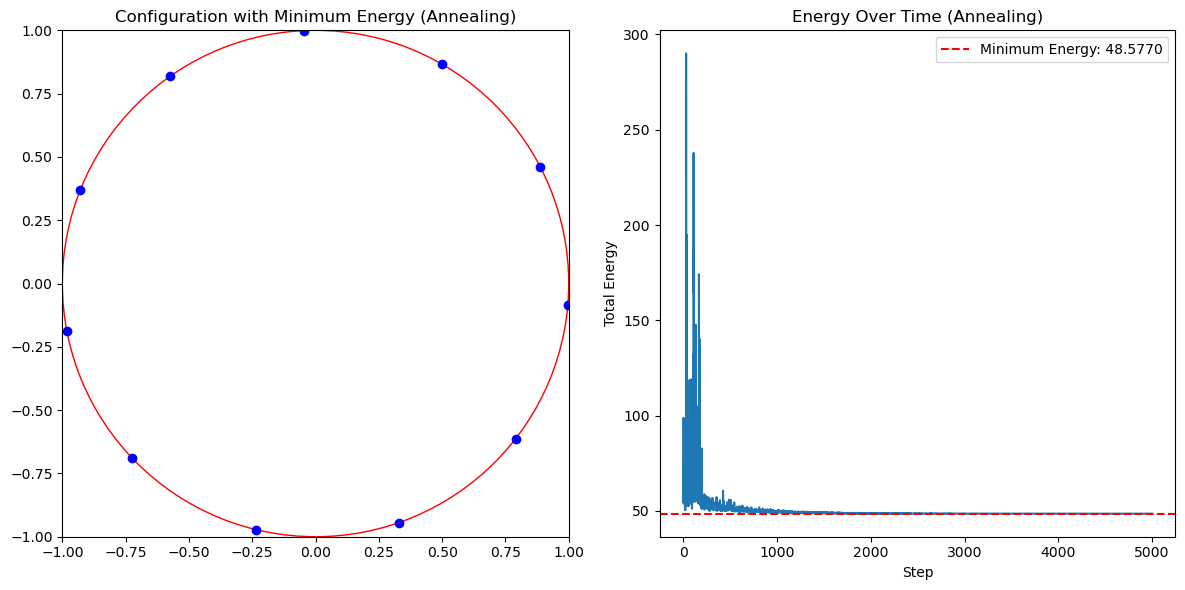

In [185]:
# Parameters
n_particles = 11 
circle_radius = 1
markov_chain = 100
simulation_steps = 50*markov_chain
initial_step_size = 1
final_step_size = 0.02
initial_temperature = 20*n_particles
final_temperature = 0.001

# Run the simulation with simulated annealing
annealing_particles, annealing_min_energy, annealing_energy_over_time = simulate_charged_particles_individual_steps(
    n_particles, circle_radius, simulation_steps, initial_step_size, final_step_size, initial_temperature, final_temperature, markov_chain=markov_chain, cooling='linear'
)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Configuration with minimum energy (annealing)
circle = plt.Circle((0, 0), circle_radius, color='r', fill=False)
ax[0].add_artist(circle)
ax[0].scatter(annealing_particles[:, 0], annealing_particles[:, 1], color='blue')
ax[0].set_xlim([-circle_radius, circle_radius])
ax[0].set_ylim([-circle_radius, circle_radius])
ax[0].set_title("Configuration with Minimum Energy (Annealing)")
ax[0].set_aspect('equal', 'box')

# Energy over time (annealing)
ax[1].plot(annealing_energy_over_time)
ax[1].set_title("Energy Over Time (Annealing)")
ax[1].set_xlabel("Step")
ax[1].set_ylabel("Total Energy")
ax[1].axhline(y=annealing_min_energy, color='r', linestyle='--', label=f'Minimum Energy: {annealing_min_energy:.4f}')
ax[1].legend()

plt.tight_layout()

0 0.9962785438078025 870.9635899560806
1000 1.2652096918967999 218.77616239495512
2000 1.278249167131217 54.9540873857624
3000 0.9162050657365662 13.803842646028825
4000 0.6423927351113543 3.467368504525308
5000 0.03160704219857625 0.8709635899560783
6000 1.1313059324206038 0.2187761623949545
7000 0.0009631946234994047 0.05495408738576224
8000 6.110395179024105e-07 0.013803842646028784
9000 0.012049642348515549 0.003467368504525297


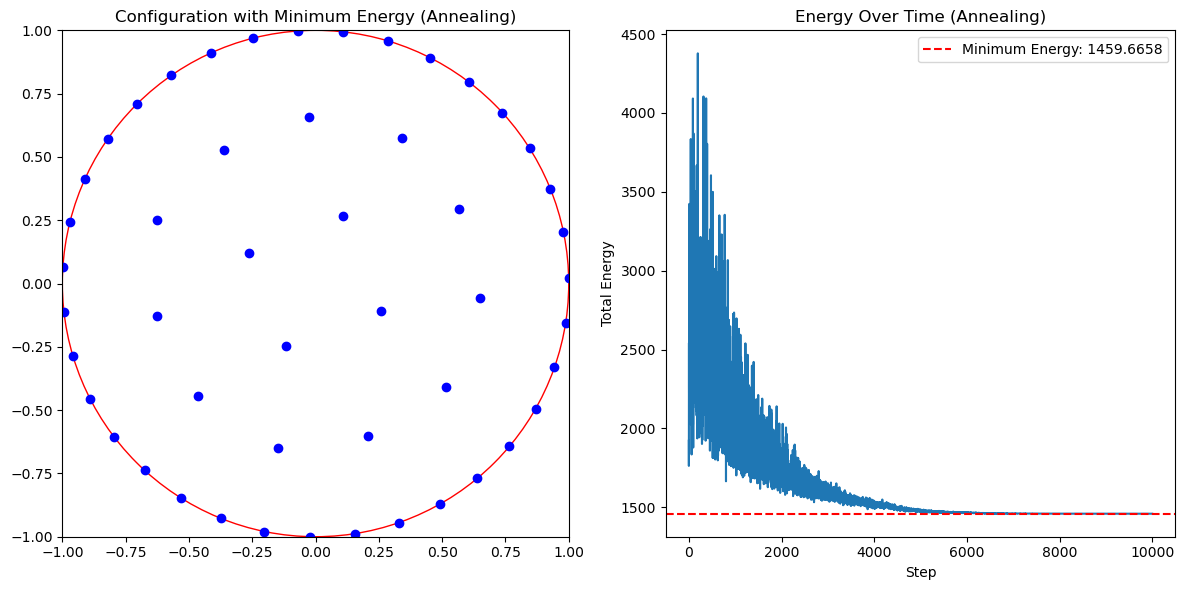

In [126]:
# Parameters
n_particles = 50 # Number of particles
circle_radius = 1
simulation_steps = 10_000
initial_step_size = 1
final_step_size = 0.02
initial_temperature = 20*n_particles
final_temperature = 0.001

# Run the simulation with simulated annealing
annealing_particles, annealing_min_energy, annealing_energy_over_time = simulate_charged_particles_individual_steps(
    n_particles, circle_radius, simulation_steps, initial_step_size, final_step_size, initial_temperature, final_temperature
)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Configuration with minimum energy (annealing)
circle = plt.Circle((0, 0), circle_radius, color='r', fill=False)
ax[0].add_artist(circle)
ax[0].scatter(annealing_particles[:, 0], annealing_particles[:, 1], color='blue')
ax[0].set_xlim([-circle_radius, circle_radius])
ax[0].set_ylim([-circle_radius, circle_radius])
ax[0].set_title("Configuration with Minimum Energy (Annealing)")
ax[0].set_aspect('equal', 'box')

# Energy over time (annealing)
ax[1].plot(annealing_energy_over_time)
ax[1].set_title("Energy Over Time (Annealing)")
ax[1].set_xlabel("Step")
ax[1].set_ylabel("Total Energy")
ax[1].axhline(y=annealing_min_energy, color='r', linestyle='--', label=f'Minimum Energy: {annealing_min_energy:.4f}')
ax[1].legend()

plt.tight_layout()

0 0.966416025368237 460
1000 1.1397327484404882 33.90051261945959
2000 0.6938772778600106 2.4983581649176956
3000 0.25509589676651206 0.18412091847330947
4000 0.9456737231637261 0.013569116348284598


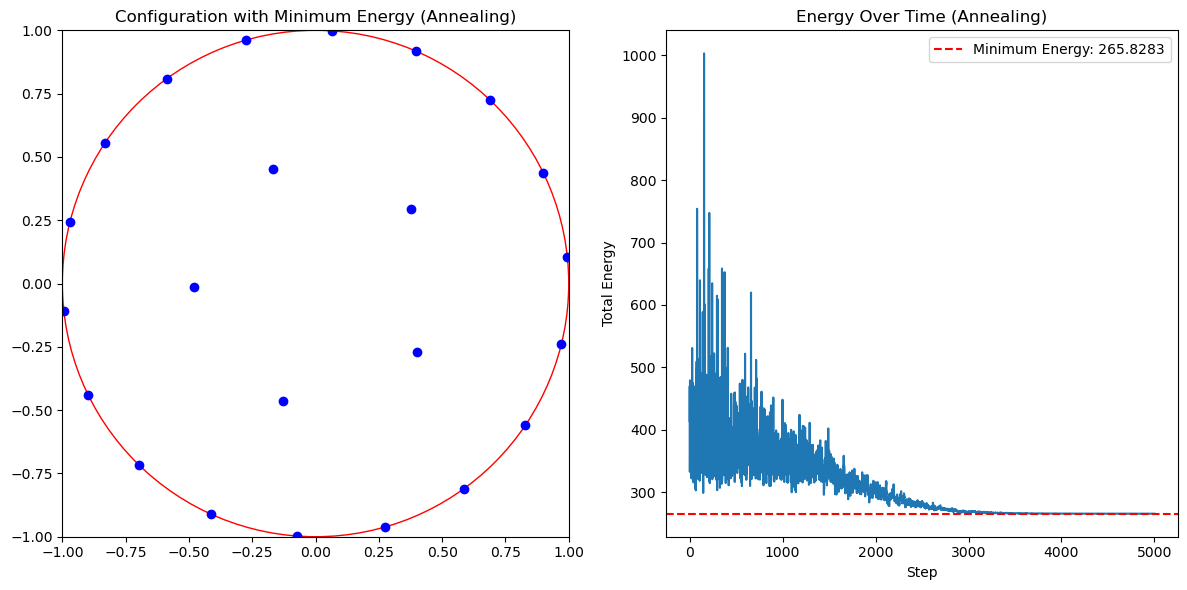

In [71]:
# Parameters
n_particles = 23 # Number of particles
circle_radius = 1
simulation_steps = 5_000
initial_step_size = 1
final_step_size = 0.02
initial_temperature = 20*n_particles
final_temperature = 0.001

# Run the simulation with simulated annealing
annealing_particles, annealing_min_energy, annealing_energy_over_time = simulate_charged_particles_individual_steps(
    n_particles, circle_radius, simulation_steps, initial_step_size, final_step_size, initial_temperature, final_temperature
)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Configuration with minimum energy (annealing)
circle = plt.Circle((0, 0), circle_radius, color='r', fill=False)
ax[0].add_artist(circle)
ax[0].scatter(annealing_particles[:, 0], annealing_particles[:, 1], color='blue')
ax[0].set_xlim([-circle_radius, circle_radius])
ax[0].set_ylim([-circle_radius, circle_radius])
ax[0].set_title("Configuration with Minimum Energy (Annealing)")
ax[0].set_aspect('equal', 'box')

# Energy over time (annealing)
ax[1].plot(annealing_energy_over_time)
ax[1].set_title("Energy Over Time (Annealing)")
ax[1].set_xlabel("Step")
ax[1].set_ylabel("Total Energy")
ax[1].axhline(y=annealing_min_energy, color='r', linestyle='--', label=f'Minimum Energy: {annealing_min_energy:.4f}')
ax[1].legend()

plt.tight_layout()
plt.show()

0 1.0185881750252521 172.01813199719922
1000 0.9969435579230823 14.692296734695834
2000 1.0038062936322718 1.2548885447952
3000 1.4222734450780934 0.10718169448207891
4000 1.113743285713919 0.009154530639152938
0 0.9535983465943753 187.3298635905663
1000 0.9948981662384961 15.724062758871522
2000 1.1094592910093677 1.3198437499816837
3000 1.08279214502392 0.11078482394016666
4000 1.3318562767619258 0.009299038022966014
0 0.9925310652215633 202.6160670198578
1000 1.0020001618955612 16.737061479876257
2000 0.9843681101194243 1.3825617637405971
3000 1.0090630573429915 0.11420625017454633
4000 0.8200019029178102 0.009433985461627643
0 1.003918298112788 217.87874784957984
1000 1.0121448081421673 17.733042888830347
2000 0.9603055359122203 1.4432835382099565
3000 1.4713543252628944 0.11746812911505049
4000 2.1250242441859024 0.009560672586139374
0 0.9986229745779559 233.1196216783771
1000 1.0176622697316557 18.713480918305443
2000 1.0335475740570266 1.502208889833078
3000 0.6442225963712414 0

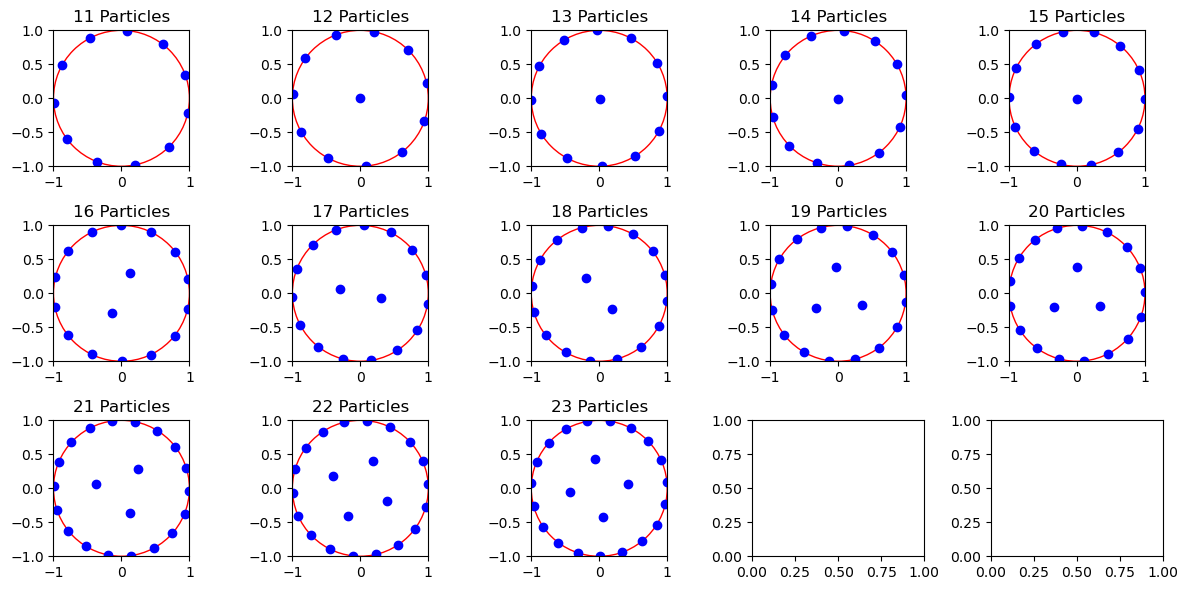

In [128]:

# Parameters
circle_radius = 1
simulation_steps = 5_000
initial_step_size = 1
final_step_size = 0.02
# initial_temperature = 500
final_temperature = 0.001

# Number of rows and columns in the subplot grid
nrows = 3
ncols = 5

# Create a figure with subplots
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 6))

# Iterate over the specified number of particles
for i, n_particles in enumerate(range(11, 24)):

    initial_temperature = 20 * n_particles
    # Run the simulation for each particle count
    annealing_particles, _, _ = simulate_charged_particles_individual_steps(
        n_particles, circle_radius, simulation_steps, initial_step_size, final_step_size, initial_temperature, final_temperature
    )

    # Plot the configuration for each particle count
    ax = axes[i // ncols, i % ncols]  # Select the correct subplot
    circle = plt.Circle((0, 0), circle_radius, color='r', fill=False)
    ax.add_artist(circle)
    ax.scatter(annealing_particles[:, 0], annealing_particles[:, 1], color='blue')
    ax.set_xlim([-circle_radius, circle_radius])
    ax.set_ylim([-circle_radius, circle_radius])
    ax.set_title(f"{n_particles} Particles")
    ax.set_aspect('equal', 'box')

plt.tight_layout()
plt.show()

In [53]:
def basic_cooling(T0, TN, steps, chain_length):
    return (TN/T0)**(chain_length/steps)

def exponential_cooling(T0,t,a=0.9):
    return T0*a**t

def linear_cooling(T0,t,e):
    return T0-t*e

def logarithmic_cooling(T0,t,c,d):
    return c/np.log(t+d)


### Exponential cooling

In [54]:
def simulate_exp_annealing(n, radius, steps, initial_step_size, final_step_size, initial_temp, final_temp):
    """ Simulate the charged particles with simulated annealing, updating all particles at once. """
    particles = initialize_particles_center_bias(n, radius)
    min_energy_config = None
    min_energy = np.inf
    energies = []

    temperature = initial_temp
    step_size = initial_step_size

    # Calculate the cooling and step size rates
    # cooling_rate = (final_temp / initial_temp) ** (1 / steps)
    step_rate = (final_step_size / initial_step_size) ** (1 / steps)

    for step in range(steps):

        forces, current_energy = compute_forces_and_energy_vectorized(particles, radius)

        # Calculate new positions for all particles
        new_particles = update_particle_positions(particles, step_size, radius)
        new_energy = compute_forces_and_energy_vectorized(new_particles, radius)[1]

        # Decide whether to accept the new configuration
        if new_energy < current_energy or np.random.rand() < np.exp((current_energy - new_energy) / temperature):
            particles = new_particles
            current_energy = new_energy
        print(step, np.exp((current_energy - new_energy) / temperature), temperature)
        # Update energy, temperature, and step size after each step
        energy = compute_forces_and_energy_vectorized(particles, radius)[1]
        energies.append(energy)

        if energy < min_energy:
            min_energy = energy
            min_energy_config = particles.copy()

       
        temperature = exponential_cooling(initial_temperature,step,0.99)
        step_size *= step_rate

    return min_energy_config, min_energy, energies

In [55]:

# Parameters
n_particles = 11  # Number of particles
circle_radius = 1  # Radius of the circle
simulation_steps = 7500  # Number of steps in the simulation
initial_step_size = 0.3
final_step_size = 0.01
initial_temperature = 250  # Reduced initial temperature
final_temperature = 0.001  # Reduced final temperature


# Run the simulation with simulated annealing
annealing_particles, annealing_min_energy, annealing_energy_over_time = simulate_exp_annealing(
    n_particles, circle_radius, simulation_steps, initial_step_size, final_step_size, initial_temperature, final_temperature
)

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Configuration with minimum energy (annealing)
circle = plt.Circle((0, 0), circle_radius, color='r', fill=False)
ax[0].add_artist(circle)
ax[0].scatter(annealing_particles[:, 0], annealing_particles[:, 1], color='blue')
ax[0].set_xlim([-circle_radius, circle_radius])
ax[0].set_ylim([-circle_radius, circle_radius])
ax[0].set_title("Configuration with Minimum Energy (Annealing)")
ax[0].set_aspect('equal', 'box')

# Energy over time (annealing)
ax[1].plot(annealing_energy_over_time)
ax[1].set_title("Energy Over Time (Annealing)")
ax[1].set_xlabel("Step")
ax[1].set_ylabel("Total Energy")
ax[1].axhline(y=annealing_min_energy, color='r', linestyle='--', label=f'Minimum Energy: {annealing_min_energy:.4f}')
ax[1].legend()

plt.tight_layout()
plt.show()

TypeError: compute_forces_and_energy_vectorized() takes 1 positional argument but 2 were given